In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BASE_PATH = r'C:\Users\Sameer\Desktop\dog_images'
CLASSES = ['chihuahua', 'husky', 'shiba']

In [7]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    BASE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

# Print class indices and sample counts
print("Class indices:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of test samples:", test_generator.samples)

# Calculate steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Found 8445 images belonging to 3 classes.
Found 2109 images belonging to 3 classes.
Found 10554 images belonging to 3 classes.
Class indices: {'chihuahua': 0, 'husky': 1, 'shiba': 2}
Number of training samples: 8445
Number of validation samples: 2109
Number of test samples: 10554
Steps per epoch: 263
Validation steps: 65


In [8]:
def create_model(base_model, model_name):
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')  # 3 units for 3 classes
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create models
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_model = create_model(resnet_base, "ResNet50")
densenet_model = create_model(densenet_base, "DenseNet121")
mobilenet_model = create_model(mobilenet_base, "MobileNetV3")

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

In [9]:
def train_and_evaluate_model(model, model_name):
    start_time = time.time()
    
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
    )
    
    training_time = time.time() - start_time
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator)
    
    # Calculate mAP
    y_pred = model.predict(test_generator)
    y_true = test_generator.classes
    y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=3)
    mAP = average_precision_score(y_true_onehot, y_pred, average='macro')
    
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} - mAP: {mAP:.4f}")
    print(f"{model_name} - Training Time: {training_time:.2f} seconds")
    
    return history, test_accuracy, mAP, training_time

# Train and evaluate each model
print("Starting model training...")
resnet_history, resnet_accuracy, resnet_map, resnet_time = train_and_evaluate_model(resnet_model, "ResNet50")
densenet_history, densenet_accuracy, densenet_map, densenet_time = train_and_evaluate_model(densenet_model, "DenseNet121")
mobilenet_history, mobilenet_accuracy, mobilenet_map, mobilenet_time = train_and_evaluate_model(mobilenet_model, "MobileNetV3")

Starting model training...


C:\Users\Sameer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - accuracy: 0.3373 - loss: 1.2344 - val_accuracy: 0.3505 - val_loss: 1.0947 - learning_rate: 1.0000e-04
Epoch 2/50
  1/263 ━━━━━━━━━━━━━━━━━━━━ 10:33 2s/step - accuracy: 0.2188 - loss: 1.1807

C:\Users\Sameer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


263/263 ━━━━━━━━━━━━━━━━━━━━ 161s 605ms/step - accuracy: 0.2188 - loss: 1.1807 - val_accuracy: 0.3596 - val_loss: 1.0936 - learning_rate: 1.0000e-04
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.3564 - loss: 1.1060 - val_accuracy: 0.3404 - val_loss: 1.0923 - learning_rate: 1.0000e-04
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 158s 592ms/step - accuracy: 0.3750 - loss: 1.0945 - val_accuracy: 0.3510 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - accuracy: 0.3707 - loss: 1.0928 - val_accuracy: 0.3923 - val_loss: 1.0864 - learning_rate: 1.0000e-04
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 160s 601ms/step - accuracy: 0.2500 - loss: 1.1396 - val_accuracy: 0.3909 - val_loss: 1.0869 - learning_rate: 1.0000e-04
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 0.3698 - loss: 1.0905 - val_accuracy: 0.4149 - val_loss: 1.0853 - learning_rate: 1.0000e-04
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 159s 599ms/step - ac

C:\Users\Sameer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


263/263 ━━━━━━━━━━━━━━━━━━━━ 166s 624ms/step - accuracy: 0.7500 - loss: 0.6147 - val_accuracy: 0.7981 - val_loss: 0.4951 - learning_rate: 1.0000e-04
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 834s 3s/step - accuracy: 0.7115 - loss: 0.6504 - val_accuracy: 0.8264 - val_loss: 0.4392 - learning_rate: 1.0000e-04
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 164s 616ms/step - accuracy: 0.6875 - loss: 0.6967 - val_accuracy: 0.8173 - val_loss: 0.4384 - learning_rate: 1.0000e-04
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.7559 - loss: 0.5717 - val_accuracy: 0.8322 - val_loss: 0.4127 - learning_rate: 1.0000e-04
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 163s 614ms/step - accuracy: 0.7812 - loss: 0.5556 - val_accuracy: 0.8236 - val_loss: 0.4176 - learning_rate: 1.0000e-04
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.7724 - loss: 0.5313 - val_accuracy: 0.8351 - val_loss: 0.3995 - learning_rate: 1.0000e-04
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 162s 611ms/step - ac

C:\Users\Sameer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


263/263 ━━━━━━━━━━━━━━━━━━━━ 60s 225ms/step - accuracy: 0.3125 - loss: 1.1505 - val_accuracy: 0.3481 - val_loss: 1.0962 - learning_rate: 1.0000e-04
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.3418 - loss: 1.1187 - val_accuracy: 0.3428 - val_loss: 1.0967 - learning_rate: 1.0000e-04
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 60s 225ms/step - accuracy: 0.4375 - loss: 1.0808 - val_accuracy: 0.3438 - val_loss: 1.0966 - learning_rate: 1.0000e-04
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.3557 - loss: 1.1028 - val_accuracy: 0.3803 - val_loss: 1.0941 - learning_rate: 1.0000e-04
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 60s 225ms/step - accuracy: 0.3125 - loss: 1.0698 - val_accuracy: 0.3817 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.3483 - loss: 1.1025 - val_accuracy: 0.3697 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 60s 226ms/step - accura

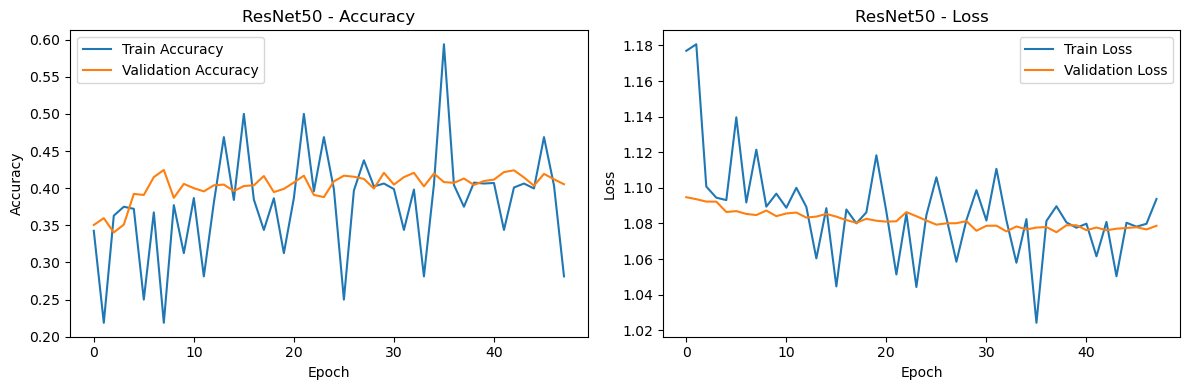

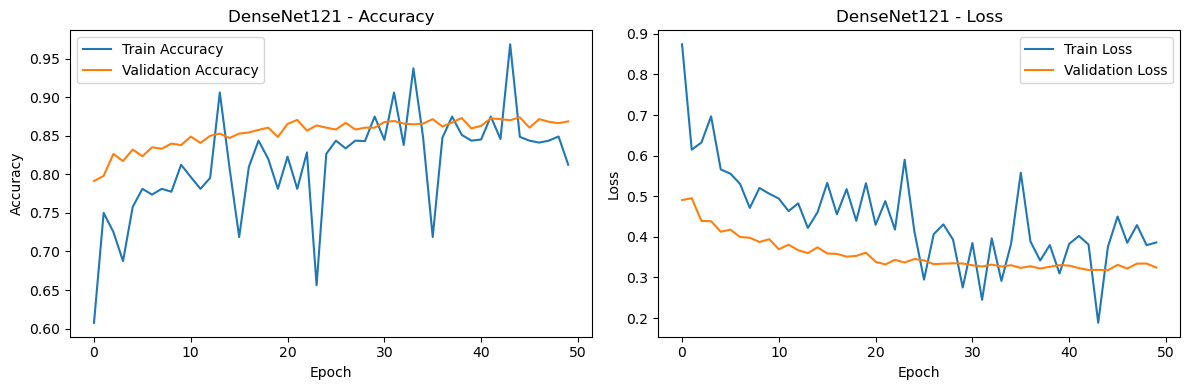

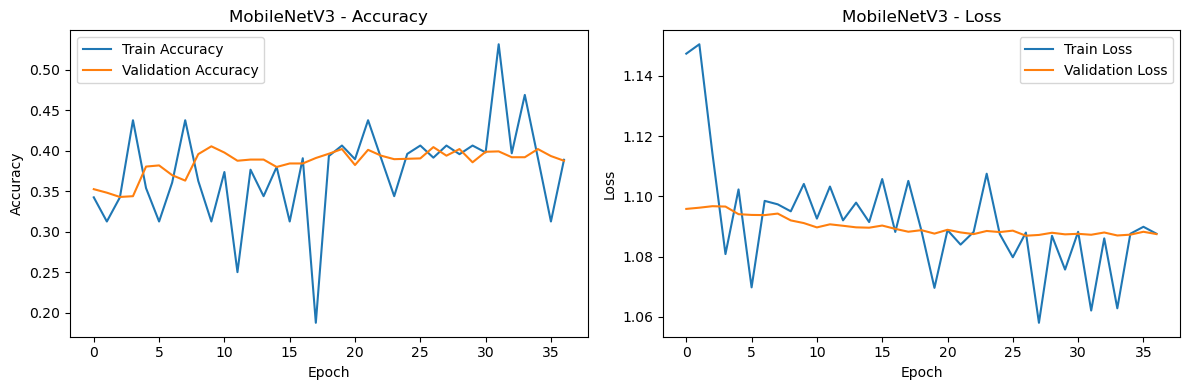

In [11]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_training_history(resnet_history, "ResNet50")
plot_training_history(densenet_history, "DenseNet121")
plot_training_history(mobilenet_history, "MobileNetV3")

330/330 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step


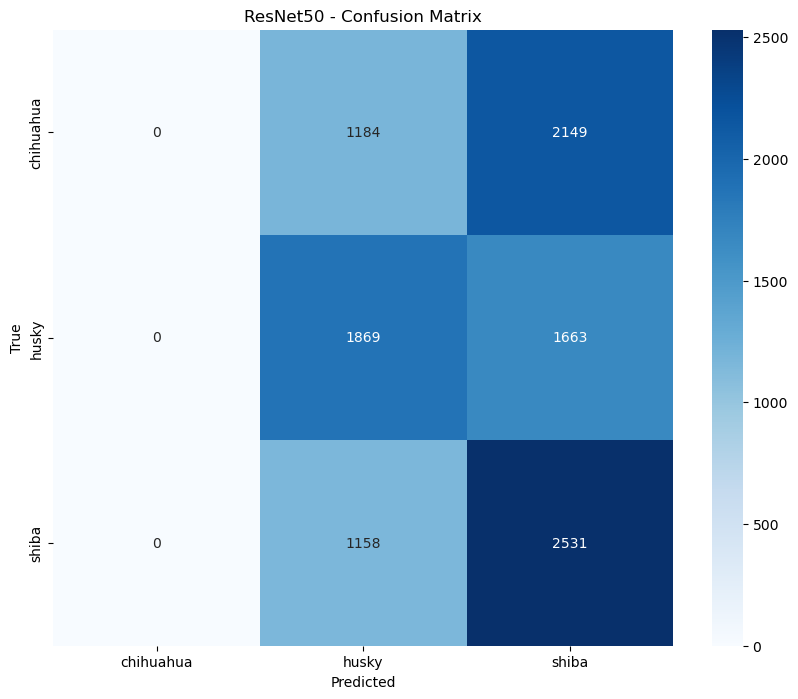

330/330 ━━━━━━━━━━━━━━━━━━━━ 852s 3s/step


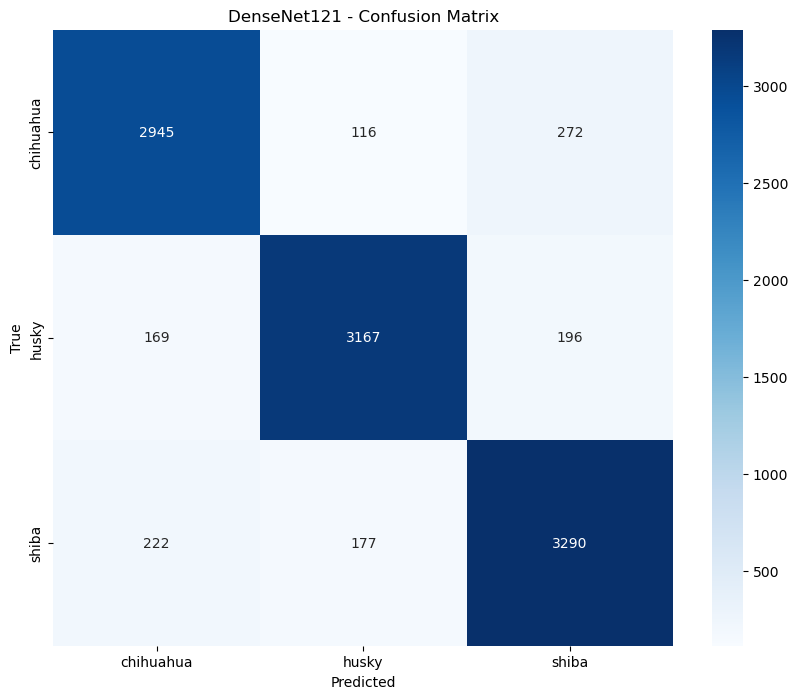

330/330 ━━━━━━━━━━━━━━━━━━━━ 277s 839ms/step


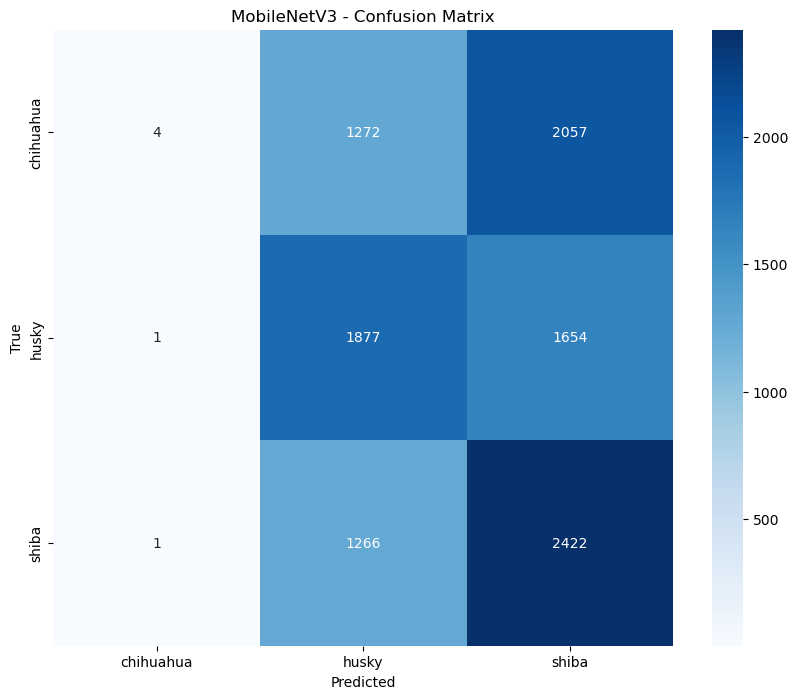

In [12]:
def plot_confusion_matrix(model, generator, model_name):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(resnet_model, test_generator, "ResNet50")
plot_confusion_matrix(densenet_model, test_generator, "DenseNet121")
plot_confusion_matrix(mobilenet_model, test_generator, "MobileNetV3")

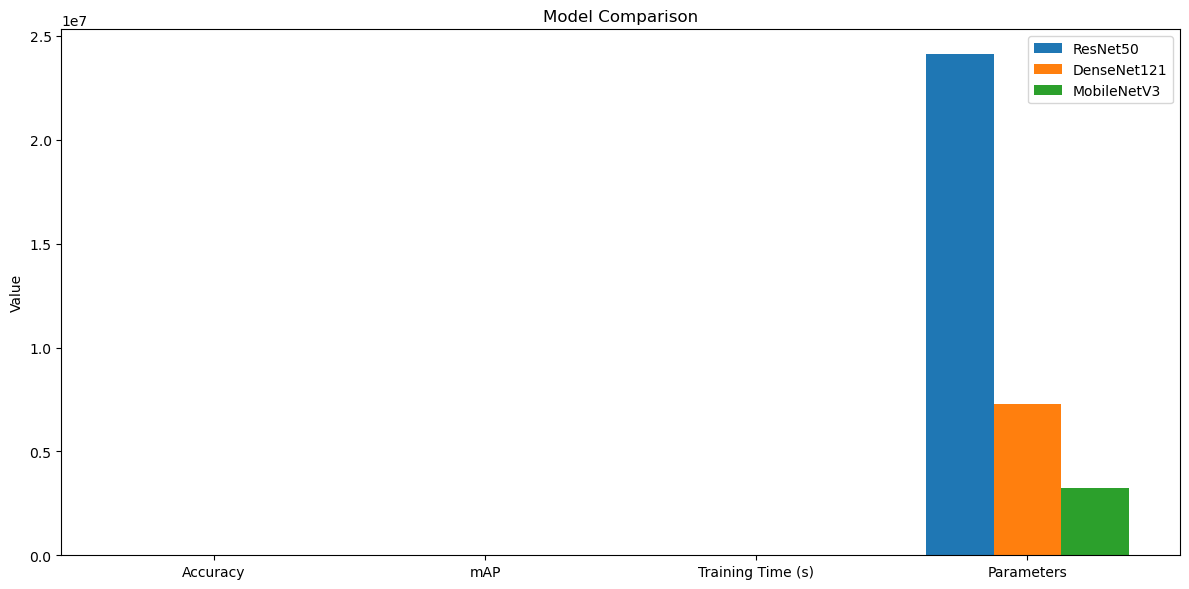


Detailed Model Comparison:
Model           Accuracy   mAP        Training Time   Parameters
------------------------------------------------------------
ResNet50        0.4169     0.4240     21418.25s          24113027
DenseNet121     0.8908     0.9614     24139.56s          7300675
MobileNetV3     0.4077     0.4054     6904.09s          3243139


In [13]:
def compare_models(models_data):
    metrics = ['Accuracy', 'mAP', 'Training Time (s)', 'Parameters']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, (model_name, data) in enumerate(models_data.items()):
        ax.bar(x + i*width, data, width, label=model_name)
    
    ax.set_ylabel('Value')
    ax.set_title('Model Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare data for comparison
models_data = {
    'ResNet50': [resnet_accuracy, resnet_map, resnet_time, resnet_model.count_params()],
    'DenseNet121': [densenet_accuracy, densenet_map, densenet_time, densenet_model.count_params()],
    'MobileNetV3': [mobilenet_accuracy, mobilenet_map, mobilenet_time, mobilenet_model.count_params()]
}

# Compare models
compare_models(models_data)

# Print detailed comparison
print("\nDetailed Model Comparison:")
print(f"{'Model':<15} {'Accuracy':<10} {'mAP':<10} {'Training Time':<15} {'Parameters'}")
print("-" * 60)
for model_name, data in models_data.items():
    print(f"{model_name:<15} {data[0]:.4f}     {data[1]:.4f}     {data[2]:.2f}s          {data[3]}")